In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline


### 1.数据导入

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

input_dir = 'Kesci-data/'

register = pd.read_csv(input_dir + 'user_register_log.txt', sep='\t',
                    names=['user_id','register_day','register_type','device_type'],
                    dtype={0: np.uint32, 1: np.uint8, 2: np.uint8, 3: np.uint16})
launch = pd.read_csv(input_dir + 'app_launch_log.txt', sep='\t',
                  names=['user_id', 'launch_day'],
                  dtype={0: np.uint32, 1: np.uint8})
video = pd.read_csv(input_dir + 'video_create_log.txt', sep='\t',
                  names=['user_id', 'video_day'],
                  dtype={0: np.uint32, 1: np.uint8})
activity = pd.read_csv(input_dir + 'user_activity_log.txt', sep='\t',
                    names=['user_id','activity_day','page','video_id','author_id','action_type'],
                    dtype={0: np.uint32, 1: np.uint8, 2: np.uint8, 3: np.uint32, 4: np.uint32, 5: np.uint8})

### 2.EDA（更多方法可参考书籍《利用python进行数据分析》）

In [29]:
register.sample(10)

,user_id,register_day,register_type,device_type
37491,1293541,7,1,97
37896,1350165,21,1,1119
6081,312260,2,0,32
44118,1302088,16,1,7
17064,398517,11,4,2
12989,109470,27,1,401
35306,414257,24,2,10
46722,29816,10,0,18
48167,553894,1,0,37
49153,6224,15,2,58


In [62]:
register.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51709 entries, 0 to 51708
Data columns (total 4 columns):
user_id          51709 non-null uint32
register_day     51709 non-null uint8
register_type    51709 non-null uint8
device_type      51709 non-null uint16
dtypes: uint16(1), uint32(1), uint8(2)
memory usage: 404.0 KB


In [40]:
#每天的注册用户数
# register.groupby(by=['register_day']).size()
register['register_day'].value_counts()

24    3072
21    2439
22    2389
23    2312
27    2197
28    2186
13    2157
14    2053
6     1863
29    1821
20    1794
30    1788
7     1708
12    1658
26    1644
18    1611
15    1557
25    1555
19    1534
17    1519
16    1506
11    1462
10    1401
5     1324
8     1231
3     1224
1     1200
9     1179
4     1167
2     1158
Name: register_day, dtype: int64

#### 2.1分析异常值

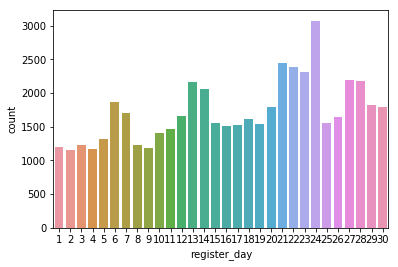

In [42]:
sns.countplot(x='register_day',data=register)  #可以看出24号这天的数据显著增多

D:\Anaconda3\envs\py27\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


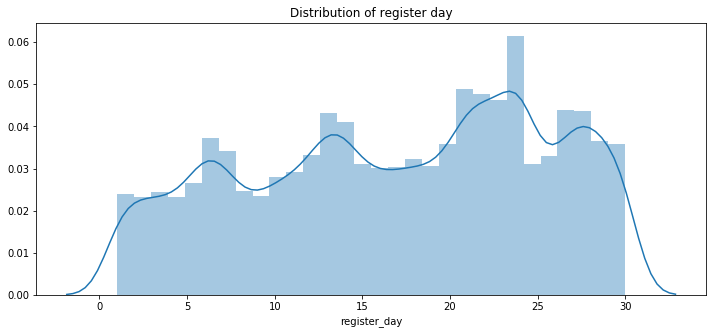

In [43]:
plt.figure(figsize=(12,5))
plt.title("Distribution of register day")
ax = sns.distplot(register["register_day"],bins=30)

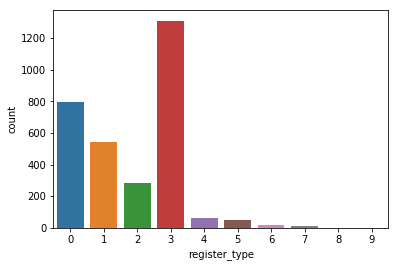

In [44]:
sns.countplot(x='register_type',data=register[register['register_day']==24])

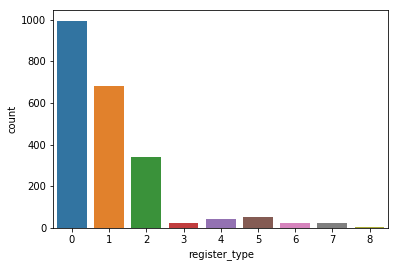

In [49]:
sns.countplot(x='register_type',data=register[register['register_day']==28])

In [61]:
register[(register["register_day"]==24)&(register["register_type"]==3)]["device_type"].value_counts()

1        1107
83        107
223        65
10          3
648         2
485         1
35          1
4157        1
66          1
87          1
2218        1
266         1
2352        1
438         1
443         1
12052       1
1565        1
527         1
578         1
636         1
2741        1
694         1
720         1
908         1
941         1
952         1
1168        1
1322        1
1498        1
486         1
Name: device_type, dtype: int64

In [60]:
user_outliers = register[(register["device_type"]==1)|((register["register_day"].isin([24]))&(register["register_type"]==3)&(register["device_type"]==1))]["user_id"].unique().tolist()
print(len(user_outliers))

1141


### 3.构建训练、验证、测试集
题目是属于时间序列分析，使用滑窗法
根据日期分割数据集：

offline-train1 用户1-9 标签10-16  
offline-train2 用户1-16 标签17-23   
offline-train3 用户1-23 标签24-30 [验证集]   
online-test 用户1-30 标签31-37  

In [ ]:
def cut_data_on_time(output_path,begin_day,end_day):
    temp_register = register[(register['register_day'] >= 1) & (register['register_day'] <= end_day)]
    temp_launch = launch[(launch['launch_day'] >= begin_day) & (launch['launch_day'] <= end_day)]
    temp_video = video[(video['video_day'] >= begin_day) & (video['video_day'] <= end_day)]
    temp_activity = activity[(activity['activity_day'] >= begin_day) & (activity['activity_day'] <= end_day)]
    
    temp_register.to_csv(output_path + '/register.csv',index=False)
    del temp_register
    temp_launch.to_csv(output_path + '/launch.csv',index=False)
    del temp_launch
    temp_video.to_csv(output_path + '/video.csv',index=False)
    del temp_video
    temp_activity.to_csv(output_path + '/activity.csv',index=False)
    del temp_activity
    
def generate_dataset():
    print('Cutting train data set 1 ...')
    begin_day = 1
    end_day = 9
    cut_data_on_time(dataset_1_feat_dir,begin_day,end_day)
    begin_day = 10
    end_day = 16
    cut_data_on_time(dataset_1_label_dir,begin_day,end_day)
    
    print('Cutting train data set 2 ...')
    begin_day = 1
    end_day = 16
    cut_data_on_time(dataset_2_feat_dir,begin_day,end_day)
    begin_day = 17
    end_day = 23
    cut_data_on_time(dataset_2_label_dir,begin_day,end_day)
    
    print('Cutting train data set 3 ...')
    begin_day = 1
    end_day = 23
    cut_data_on_time(dataset_3_feat_dir,begin_day,end_day)
    begin_day = 24
    end_day = 30
    cut_data_on_time(dataset_3_label_dir,begin_day,end_day)

    print('Cutting test data set...')
    begin_day = 1
    end_day = 30
    cut_data_on_time(dataset_4_feat_dir,begin_day,end_day)

### 4.特征工程
* 4.1 register表
  * 注册时间
  * 注册类型
  * 注册设备类型
  * 已经注册的天数
  * 注册时间的权重
* 4.2 launch表
  * launch相隔天数特征
  * 最后一次launch在哪一天
  * 第一次启动是在哪一天
  * 最后一次启动距离预测日期多少天
  * 最多启动的时间
  * 每个用户启动diff（前后差）的次数、最大值、最小值、平均值、标准差、峰度、偏度
  * 滑动时间窗口启动的次数、启动时间权重
* 4.3 video表
  * 最后一次拍摄视频在哪一天
  * 第一次拍摄视频在哪一天
  * 最后一次拍摄视频距离预测日期多少天
  * 最多拍摄视频的时间
  * 拍摄视频diff（前后差）的次数、最大值、最小值、平均值、标准差、峰度、偏度
  * 滑动时间窗口拍摄视频的次数、拍摄视频的时间权重
* 4.4 activity表
  * 最后一次活动在哪一天
  * 第一次活动在哪一天
  * 最后一次活动距离预测日期多少天
  * 最多活动的时间
  * 活动diff（前后差）的次数、最大值、最小值、平均值、标准差、峰度、偏度
  * 滑动时间窗口活动的次数、活动的时间权重
  * 行为日志还可以对page和action_type提取一些分组统计特征
* 4.5 组合特征
  * 注册后与最后一次启动的相隔天数
  * 注册后与最后一次拍摄的相隔天数
  * 注册后与最后一次活动的相隔天数
  * 用户创作视频被观看的概率
  * 用户启动、拍摄视频、活动的平均次数


In [ ]:
''' 其中的launch特征提取 '''

def launch_slide_window(launch):
    launch_total_count = launch[['user_id']].groupby(['user_id']).size().rename('launch_total_count').reset_index()
    
    # 加入权重信息
    launch['app_launch_log_flag'] = launch['app_launch_log_flag'].fillna(0)
    launch_date = np.max(launch['launch_day'])
    launch['weight'] = launch_date + 1- launch['launch_day']
    launch['weight'] = 1 / launch['weight']
    launch['app_launch_log_flag'] = launch['app_launch_log_flag'] * launch['weight']
    launch_time_feat = launch.groupby(['user_id'])['app_launch_log_flag'].sum().rename('windows_launch_feat').reset_index()

    return launch_total_count,launch_time_feat

def get_launch_feature(launch):
    feature = pd.DataFrame()
    feature['user_id'] = launch['user_id'].drop_duplicates()
    end_day = np.max(launch['launch_day'])
    #滑窗 窗口内launch次数
    launch_total_count_all, launch_time_feat_all=launch_slide_window(launch)
    launch_total_count_1 , launch_time_feat_1=launch_slide_window(launch[(launch['launch_day']>=end_day) & (launch['launch_day']<=end_day)])
    launch_total_count_2, launch_time_feat_2=launch_slide_window(launch[(launch['launch_day']>=end_day-1) & (launch['launch_day']<=end_day)])
    launch_total_count_3, launch_time_feat_3=launch_slide_window(launch[(launch['launch_day']>=end_day-2) & (launch['launch_day']<=end_day)])
    launch_total_count_5, launch_time_feat_5=launch_slide_window(launch[(launch['launch_day']>=end_day-4) & (launch['launch_day']<=end_day)])
    launch_total_count_7, launch_time_feat_7=launch_slide_window(launch[(launch['launch_day']>=end_day-6) & (launch['launch_day']<=end_day)])
    launch_total_count_10, launch_time_feat_10=launch_slide_window(launch[(launch['launch_day']>=end_day-9) & (launch['launch_day']<=end_day)])
    #launch相隔天数特征
    launch_day_diff = pd.concat([launch['user_id'],launch.groupby(['user_id']).diff().rename({'launch_day':'launch_day_diff'},axis=1)],axis=1)
    launch_day_diff_max = launch_day_diff.groupby(['user_id'])['launch_day_diff'].max().rename('launch_day_diff_max').reset_index()
    launch_day_diff_min = launch_day_diff.groupby(['user_id'])['launch_day_diff'].min().rename('launch_day_diff_min').reset_index()
    launch_day_diff_mean = launch_day_diff.groupby(['user_id'])['launch_day_diff'].mean().rename('launch_day_diff_mean').reset_index()
    launch_day_diff_std = launch_day_diff.groupby(['user_id'])['launch_day_diff'].std().rename('launch_day_diff_std').reset_index()
    launch_day_diff_kurt = launch_day_diff.groupby(['user_id'])['launch_day_diff'].agg(lambda x: pd.Series.kurt(x)).rename('launch_day_diff_kurt').reset_index()
    launch_day_diff_skew = launch_day_diff.groupby(['user_id'])['launch_day_diff'].skew().rename('launch_day_diff_skew').reset_index()
    launch_day_diff_last = launch_day_diff.groupby(['user_id'])['launch_day_diff'].last().rename('launch_day_diff_last').reset_index()

    #最后一次launch在哪一天
    launch_last_day = launch.groupby(['user_id'])['launch_day'].max().rename('launch_last_day').reset_index()
    
    #第一次启动是在哪一天
    launch_first_day = launch.groupby(['user_id'])['launch_day'].min().rename('launch_first_day').reset_index()

    #最后一次launch到end day隔了多久
    launch_rest_day = (launch.groupby(['user_id'])['launch_day'].max()-end_day).rename('launch_rest_day').reset_index()
    launch_rest_day['launch_rest_day'] = -launch_rest_day['launch_rest_day']
    #按天统计特征
    launch_count = launch.groupby(['user_id','launch_day']).agg({'launch_day':'count'}).rename({'launch_day':'launch_count'},axis=1).reset_index()
    launch_count_max = launch_count.groupby(['user_id'])['launch_count'].max().rename('launch_count_max').reset_index()
    launch_count_min = launch_count.groupby(['user_id'])['launch_count'].min().rename('launch_count_min').reset_index()
    launch_count_mean = launch_count.groupby(['user_id'])['launch_count'].mean().rename('launch_count_mean').reset_index()
    launch_count_std = launch_count.groupby(['user_id'])['launch_count'].std().rename('launch_count_std').reset_index()
    launch_count_kurt = launch_count.groupby(['user_id'])['launch_count'].agg(lambda x: pd.Series.kurt(x)).rename('launch_count_kurt').reset_index()
    launch_count_skew = launch_count.groupby(['user_id'])['launch_count'].skew().rename('launch_count_skew').reset_index()
    launch_count_last = launch_count.groupby(['user_id'])['launch_count'].last().rename('launch_count_last').reset_index()
    launch_day_mode = launch_count.groupby(['user_id'])['launch_count'].agg(lambda x: np.mean(pd.Series.mode(x))).rename('launch_day_mode').reset_index()
    #最多launch的是哪一天
    most_launch_day = launch_count.groupby('user_id').apply(lambda x: x[x.launch_count==x.launch_count.max()]).rename({'launch_day':'most_launch_day'},axis=1).drop('launch_count',axis=1).groupby('user_id')['most_launch_day'].max().reset_index()
    most_launch_day_sub_end_day = (most_launch_day-end_day).rename({'most_launch_day':'most_launch_day_sub_end_day'},axis=1)
    #MERGE
    
    #滑窗特征
    feature = pd.merge(feature,launch_total_count_all,how='left',on='user_id')
    feature = feature.rename({'launch_total_count':'launch_total_count_all'},axis=1)
    feature = pd.merge(feature,launch_total_count_1,how='left',on='user_id')
    feature = feature.rename({'launch_total_count':'launch_total_count_1'},axis=1)
    feature = pd.merge(feature,launch_total_count_2,how='left',on='user_id')
    feature = feature.rename({'launch_total_count':'launch_total_count_2'},axis=1)
    feature = pd.merge(feature,launch_total_count_3,how='left',on='user_id')
    feature = feature.rename({'launch_total_count':'launch_total_count_3'},axis=1)
    feature = pd.merge(feature,launch_total_count_5,how='left',on='user_id')
    feature = feature.rename({'launch_total_count':'launch_total_count_5'},axis=1)
    feature = pd.merge(feature,launch_total_count_7,how='left',on='user_id')
    feature = feature.rename({'launch_total_count':'launch_total_count_7'},axis=1)
    feature = pd.merge(feature,launch_total_count_10,how='left',on='user_id')
    feature = feature.rename({'launch_total_count':'launch_total_count_10'},axis=1)
    # 加入时间权重
    feature = pd.merge(feature,launch_time_feat_all,how='left',on='user_id')
    feature = feature.rename({'launch_time_feat':'launch_time_feat_all'},axis=1)
    feature = pd.merge(feature,launch_time_feat_1,how='left',on='user_id')
    feature = feature.rename({'launch_time_feat':'launch_time_feat_1'},axis=1)
    feature = pd.merge(feature,launch_time_feat_2,how='left',on='user_id')
    feature = feature.rename({'launch_time_feat':'launch_time_feat_2'},axis=1)
    feature = pd.merge(feature,launch_time_feat_3,how='left',on='user_id')
    feature = feature.rename({'launch_time_feat':'launch_time_feat_3'},axis=1)
    feature = pd.merge(feature,launch_time_feat_5,how='left',on='user_id')
    feature = feature.rename({'launch_time_feat':'launch_time_feat_5'},axis=1)
    feature = pd.merge(feature,launch_time_feat_7,how='left',on='user_id')
    feature = feature.rename({'launch_time_feat':'launch_time_feat_7'},axis=1)
    feature = pd.merge(feature,launch_time_feat_10,how='left',on='user_id')
    feature = feature.rename({'launch_time_feat':'launch_time_feat_10'},axis=1)
    
    feature = pd.merge(feature,launch_day_diff_max,how='left',on='user_id')
    feature = pd.merge(feature,launch_day_diff_min,how='left',on='user_id')
    feature = pd.merge(feature,launch_day_diff_mean,how='left',on='user_id')
    feature = pd.merge(feature,launch_day_diff_std,how='left',on='user_id')
    feature = pd.merge(feature,launch_day_diff_kurt,how='left',on='user_id')
    feature = pd.merge(feature,launch_day_diff_skew,how='left',on='user_id')
    feature = pd.merge(feature,launch_day_diff_last,how='left',on='user_id')
    feature = pd.merge(feature,launch_last_day,how='left',on='user_id')
    feature = pd.merge(feature,launch_first_day,how='left',on='user_id')
    feature = pd.merge(feature,launch_rest_day,how='left',on='user_id')
    feature = pd.merge(feature,launch_count_max,how='left',on='user_id')
    feature = pd.merge(feature,launch_count_min,how='left',on='user_id')
    feature = pd.merge(feature,launch_count_mean,how='left',on='user_id')
    feature = pd.merge(feature,launch_count_std,how='left',on='user_id')
    feature = pd.merge(feature,launch_count_kurt,how='left',on='user_id')
    feature = pd.merge(feature,launch_count_skew,how='left',on='user_id')
    feature = pd.merge(feature,launch_count_last,how='left',on='user_id')
    feature = pd.merge(feature,launch_day_mode,how='left',on='user_id')
    feature = pd.merge(feature,most_launch_day,how='left',on='user_id')
    feature = pd.merge(feature,most_launch_day_sub_end_day,how='left',on='user_id')
    return feature

### 5.LGB模型调用
  相对于xgboost，lightgbm二分类，速度快，自动处理缺失值，内存占用更小，准确率更高。

In [ ]:
import os
import sys
import time
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")


def feature_selection(feature_mode,importance_threshold,R_threshold,P_threshold):
    train_path = '/home/kesci/train_480.csv'
    test_path = '/home/kesci/test_480.csv'
    
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    test_userid = test.pop('user_id')
    if feature_mode == 1:
        print('Loading all the features and label...')
        train_feature = train.drop(['user_id','label'],axis=1)
        train_label = train['label']
        online_test_feature = test
        print('特征数：'+ str(train_feature.columns.size))
    train_feature, offline_test_feature, train_label, offline_test_label = train_test_split(train_feature, train_label, test_size=0.1,random_state=624)
    return train_feature,train_label,online_test_feature,test_userid,offline_test_feature,offline_test_label

def auc_score(params):
    cv_auc = []
    skf = StratifiedKFold(n_splits=N,shuffle=False,random_state=624)
    for train_in,test_in in skf.split(train_feature,train_label):
        if type(train_feature)==pd.core.frame.DataFrame:
            X_train,X_test,y_train,y_test = train_feature.iloc[train_in],train_feature.iloc[test_in],train_label.iloc[train_in],train_label.iloc[test_in]
        elif type(train_feature)==np.ndarray:
            X_train,X_test,y_train,y_test = train_feature[train_in],train_feature[test_in],train_label[train_in],train_label[test_in]
    
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=lgb_eval,
                        verbose_eval=False,
                        early_stopping_rounds=20)
    
        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
        cv_auc.append(roc_auc_score(y_test,y_pred))
    mean_cv_auc = np.sum(cv_auc)/5
    return mean_cv_auc
        

def train_predict_func_cv(params):
    cv_auc = []
    offline_auc = []
    cv_prediction = []
    model_i = 0
    model_path = '/home/kesci/Kesci-file/Model/'
    print('All params:',params)
    skf = StratifiedKFold(n_splits=N,shuffle=False,random_state=624)
    for train_in,test_in in skf.split(train_feature,train_label):
        if type(train_feature)==pd.core.frame.DataFrame:
            X_train,X_test,y_train,y_test = train_feature.iloc[train_in],train_feature.iloc[test_in],train_label.iloc[train_in],train_label.iloc[test_in]
        elif type(train_feature)==np.ndarray:
            X_train,X_test,y_train,y_test = train_feature[train_in],train_feature[test_in],train_label[train_in],train_label[test_in]
    
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=lgb_eval,
                        verbose_eval=False,
                        early_stopping_rounds=20)
        
        if is_save_model:
            gbm.save_model(model_path+'model_'+str(model_i)+'.txt')
            model_i += 1
    
        y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
        cv_auc.append(roc_auc_score(y_test,y_pred))
        offline_y_pred = gbm.predict(offline_test_feature, num_iteration=gbm.best_iteration)
        offline_auc.append(roc_auc_score(offline_test_label,offline_y_pred))
        cv_prediction.append(gbm.predict(online_test_feature, num_iteration=gbm.best_iteration))
    
    mean_cv_auc = np.sum(cv_auc)/N
    mean_offline_auc = np.sum(offline_auc)/N
    mean_cv_prediction = np.sum(cv_prediction,axis=0)/N
    print('mean_cv_auc:',mean_cv_auc)
    print('mean_offline_auc:',mean_offline_auc)
    
    if is_save_result:
        result = pd.DataFrame()
        result['userid'] = list(test_userid.values)
        result['probability'] = list(mean_cv_prediction)
        time_date = time.strftime('%m-%d-%H-%M',time.localtime(time.time()))
        # submit_file_name = '%s_%s.txt'%(str(time_date),str(mean_offline_auc).split('.')[1])
        submit_file_name = '%s_%s_%s.txt'%(str(time_date),('%.6f' % mean_cv_auc).split('.')[1],('%.6f' % mean_offline_auc).split('.')[1])
        result.to_csv(submit_file_name,index=False,sep=',',header=None)
        print(submit_file_name+' 线上:{}')
    
    if is_show_importance:
        print('所用特征：'+ str(list(train_feature.columns.values)))
        # gbm = lgb.Booster(model_file=model_path+'model_'+str(1)+'.txt')
        print('所用特征重要性：'+ str(list(gbm.feature_importance())))
        fig, ax = plt.subplots(1, 1, figsize=[16, 100])
        lgb.plot_importance(gbm, ax=ax, max_num_features=700)
        plt.savefig('feature_importance.png')


if __name__ == "__main__":
    time_start = datetime.now()
    print('Start time:',time_start.strftime('%Y-%m-%d %H:%M:%S'))
    
    train_feature,train_label,online_test_feature,test_userid,offline_test_feature,offline_test_label = \
    feature_selection(feature_mode=1,importance_threshold=1,R_threshold=0.01,P_threshold=0.05) # 1:all 2:importance 3:pearson 4:importance+pearson
    
    N = 5
    is_show_importance = True
    is_save_result = True
    is_save_model = False
    
    params = {'metric': 'auc', 'boosting_type': 'gbdt', 'learning_rate': 0.02, 'num_leaves': 32, 'max_depth': 5,'objective': 'binary', 'verbose': 1,'feature_fraction': 1, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'lambda_l1': 1, 'lambda_l2': 1}
    train_predict_func_cv(params)

    time_end = datetime.now()
    print('End time:',time_end.strftime('%Y-%m-%d %H:%M:%S'))
    print('Total time:',"%.2f" % ((time_end-time_start).seconds/60),'minutes')
    

### 6.总结

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;这次的比赛是一个时间序列的分类比赛，之前有参加过华为的一个类似比赛，都是基于历史一段时间的数据预测接下来一段时间的用户标签，其中通过滑窗划分数据集很重要，快手这个比赛我们刚开始也是完全没有头绪的，所幸在比赛讨论去有大佬提供了一个baseline源码，于是我们就手敲代码复现了这个源码，终于跑通提交了第一次，有分数，挺激动的，但是分数还不如基于规则提交的分数高（直接把前一周的用户当做活跃用户），再仔细想想，发现我们的代码不够优化，虽然特征不多，但是跑完一次需要非常久的时间，于是我们一边思考优化代码和构建特征的同时寻找资料，很幸运看到了另外一个大佬的demo，于是我们通过学习参考他的代码以及结合我们的特征，在初赛的最后一次完成的大幅度的上分，于是就这样侥幸的进入了复赛。  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;进入了复赛之后，数据量翻了10倍，数据量太大了，我们原来的代码一直跑不同，输出其中的特征文件发现，生成了很多冗余特征，很明显，我们merge特征的时候重复了user_id,于是，通过进一步排查代码，折腾了四五天，终于跑通，完成了我们的第一版提交！很激动，虽然排在倒数，但是榜上有名使我们更加有动力去优化代码了。  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;接着，我们想尝试调参提高分数，因为我们已经有了561个特征了，但分数一直上不去，后来我们考虑加了些特征，达到了604特征，分数一下就上升了5个千分点，非常大的进步，后面通过调参，有上升了1个千分点，再后来一直调参分数还是上不去，最后通过重新划分数据集，增多了训练集，分数再次上升3个万分点，最后一次提交，调参上升了一个万分点，挤进前50，完成逆袭！  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;从初赛到复赛，非常幸运的是参考了讨论区各个大佬的经验，让我们作为小白有了一次很好的入门，这个比赛持续了2个月，非常感谢队友的坚持与努力让我们一直在进步，数据挖掘之路任重道远，希望下次我们取得更好的成绩！！！      ---（2018/8/14 ）  

### 7.后记
  ####  一.数据和特征决定了机器学习的上限，而模型和算法只是逼近这个上限而已。
  ####  二.每一次提交结果的记录很重要，方便对比线上线上进行调参或者融合。
  ####  三.模型融合如果选的模型太相似，反而会降分。